In [1]:
"""
Classification on CIFAR10 (ResNet)
==================================

Based on pytorch example for CIFAR10
"""


import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import matplotlib.pyplot as plt
import torch
import torch.fft
import argparse
import kymatio.datasets as scattering_datasets
from kymatio.scattering2d.core.scattering2d import scattering2d
import torch.nn as nn
from numpy.random import RandomState
import numpy as np
import pickle
import time
import mlflow
import os
from examples.utils.context import get_context
from examples.utils.wavelet_visualization import get_filters_visualization
from pathlib import Path
import yaml
import os
import sys


In [2]:
def construct_scattering(input, scattering, psi):
    if not torch.is_tensor(input):
        raise TypeError('The input should be a PyTorch Tensor.')

    if len(input.shape) < 2:
        raise RuntimeError('Input tensor must have at least two dimensions.')

    if not input.is_contiguous():
        raise RuntimeError('Tensor must be contiguous.')

    if (input.shape[-1] != scattering.N or input.shape[-2] != scattering.M) and not scattering.pre_pad:
        raise RuntimeError('Tensor must be of spatial size (%i,%i).' % (scattering.M, scattering.N))

    if (input.shape[-1] != scattering.N_padded or input.shape[-2] != scattering_padded) and scattering.pre_pad:
        raise RuntimeError('Padded tensor must be of spatial size (%i,%i).' % (scattering.M_padded, scattering.N_padded))

    if not scattering.out_type in ('array', 'list'):
        raise RuntimeError("The out_type must be one of 'array' or 'list'.")

    # phi, psi  = scattering.load_filters()
    # make_filters_diff(psi)
    # scattering.psi = psi

    batch_shape = input.shape[:-2]
    signal_shape = input.shape[-2:]

    input = input.reshape((-1,) + signal_shape)

    S = scattering2d(input, scattering.pad, scattering.unpad, scattering.backend, scattering.J,
                        scattering.L, scattering.phi, psi, scattering.max_order, scattering.out_type)

    if scattering.out_type == 'array':
        scattering_shape = S.shape[-3:]
        S = S.reshape(batch_shape + scattering_shape)
    # else:
    #     scattering_shape = S[0]['coef'].shape[-2:]
    #     new_shape = batch_shape + scattering_shape

    #     for x in S:
    #         x['coef'] = x['coef'].reshape(new_shape)

    return S

In [3]:
def make_filters_diff(psi):
    """ This function make the filters differentiable """
    # 
    filters = []
    for j in range(len(psi)):
        for k, v in psi[j].items():
            if not isinstance(k, int):
                continue
            v.requires_grad = True
            filters.append(v)
    return filters

In [4]:
class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        return x


class LinearLayer(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10, standard=False):
        super().__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k * 3
        if standard:
            self.fc = nn.Linear(3*32*32, num_classes)
        else:
            self.fc = nn.Linear(3*64*81, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)




In [5]:
def train(model, device, train_loader, is_scattering_dif, optimizer, epoch, scattering, psi):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        if is_scattering_dif:
            data = construct_scattering(data, scattering, psi)
        else:
            data = scattering(data)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, is_scattering_dif, scattering, psi):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device, dtype=torch.long)
            if is_scattering_dif:
                data = construct_scattering(data, scattering, psi)
            else:
                data = scattering(data)
            output = model(data)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [38]:
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd().parent.parent
#proj_path = current_dir.parent
proj_path = current_dir
# make the code in src available to import in this notebook
sys.path.append(os.path.join(proj_path, 'kymatio'))

#Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/data_catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)

# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, f'conf/parameters.yml'), "r") as f:
    params = yaml.safe_load(f)

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


AttributeError: 'dict' object has no attribute 'squeeze'

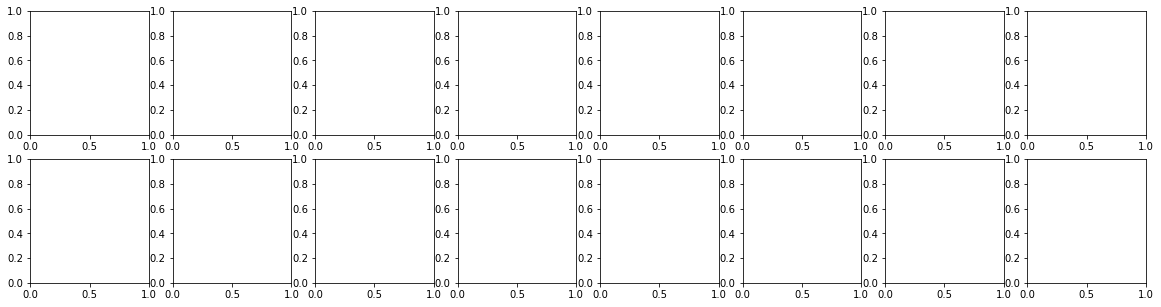

In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
is_scattering_dif = False
if params['model']['mode'] == 'scattering_dif' or params['model']['mode'] == 'scattering':
    J = params['scattering']['J']
    M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
    scattering = Scattering2D(J=J, shape=(M, N))
    K = 81*3
    model = LinearLayer(K, params['model']['width']).to(device)
    if use_cuda:
        scattering = scattering.cuda()

    phi, psi  = scattering.load_filters()
    # visualize wavlet filters before training
    filters_plots_before = {}
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_before [mode]  = f  
    if params['model']['mode'] == 'scattering_dif' :
        lr_scattering = params['model']['lr_scattering']  
        filters = make_filters_diff(psi)
        is_scattering_dif = True

else:
    model = LinearLayer(8, params['model']['width'], standard=True).to(device)
    scattering = Identity()
    psi = None
    filters_plots_before = {}


# DataLoaders
if use_cuda:
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


#####cifar data
cifar_data = datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True)
# Extract a subset of X samples per class
prng = RandomState(params['model']['seed'])
random_permute = prng.permutation(np.arange(0, 5000))[0:params['model']['num_samples']]
indx = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute] for classe in range(0, 10)])

cifar_data.data, cifar_data.targets = cifar_data.data[indx], list(np.array(cifar_data.targets)[indx])
train_loader = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=64, shuffle=True, num_workers=num_workers,
                                           pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)



In [26]:
# Optimizer
lr = params['model']['lr']
lr_scattering = params['model']['lr_scattering']  
M = params['model']['learning_schedule_multi']
drops = [60*M,120*M,160*M]
test_acc = []
start_time = time.time()
for epoch in range(0, 15):
    #for epoch in range(0, 1):
        if epoch in drops or epoch==0:
            if is_scattering_dif:
                optimizer = torch.optim.SGD([{'params': filters, 'lr': lr_scattering}, 
                                        {'params': model.parameters()}], lr=lr, momentum=0.9,
                                        weight_decay=0.0005)
                lr_scattering*=0.2
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                                        weight_decay=0.0005)
            lr*=0.2


        train(model, device, train_loader, is_scattering_dif, optimizer, epoch+1, scattering, psi)
        if epoch%10==0:
            test_acc.append(test(model, device, test_loader, is_scattering_dif, scattering, psi))


Train Epoch: 1 [0/500 (0%)]	Loss: 2.312511

Test set: Average loss: 2.2106, Accuracy: 2617/10000 (26.17%)

Train Epoch: 2 [0/500 (0%)]	Loss: 2.256543
Train Epoch: 3 [0/500 (0%)]	Loss: 2.524125
Train Epoch: 4 [0/500 (0%)]	Loss: 2.277010
Train Epoch: 5 [0/500 (0%)]	Loss: 2.928206
Train Epoch: 6 [0/500 (0%)]	Loss: 2.535602
Train Epoch: 7 [0/500 (0%)]	Loss: 2.378175
Train Epoch: 8 [0/500 (0%)]	Loss: 2.233347
Train Epoch: 9 [0/500 (0%)]	Loss: 2.441675
Train Epoch: 10 [0/500 (0%)]	Loss: 2.296916
Train Epoch: 11 [0/500 (0%)]	Loss: 2.404501

Test set: Average loss: 2.2858, Accuracy: 3481/10000 (34.81%)

Train Epoch: 12 [0/500 (0%)]	Loss: 1.959310
Train Epoch: 13 [0/500 (0%)]	Loss: 2.449455
Train Epoch: 14 [0/500 (0%)]	Loss: 2.575195
Train Epoch: 15 [0/500 (0%)]	Loss: 2.370441


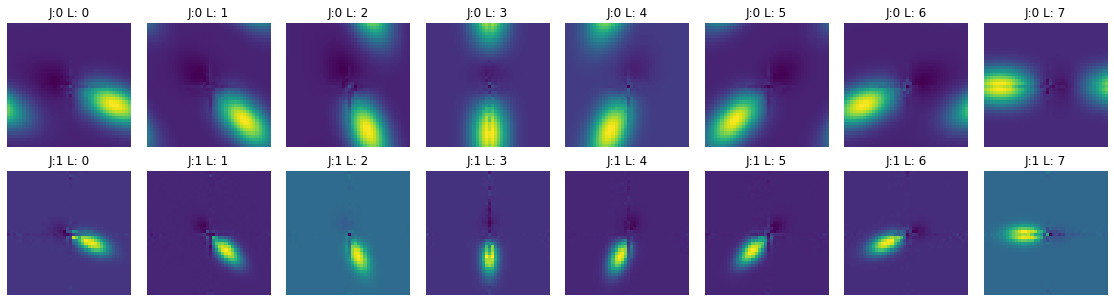

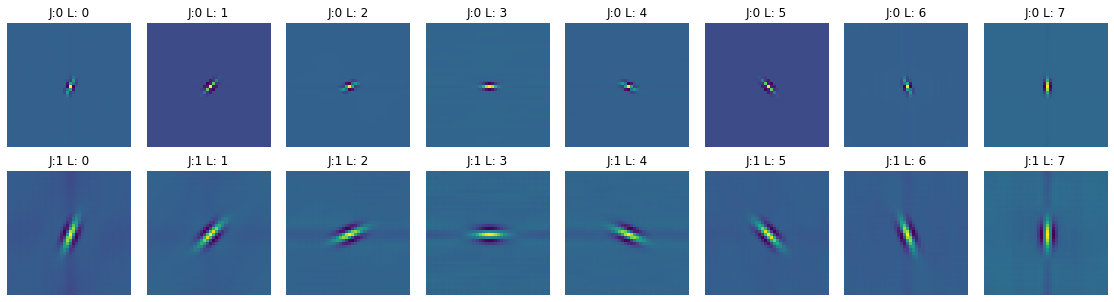

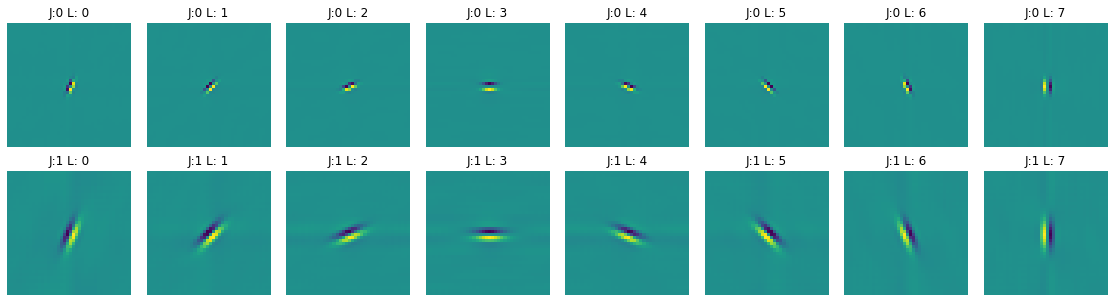

In [27]:
#visualize filters
filters_plots_after= {}
if psi is not None:
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_after[mode]  = f  

In [47]:
def periodize_filter_fft(x, res):
    """
        Parameters
        ----------
        x : numpy array
            signal to periodize in Fourier
        res :
            resolution to which the signal is cropped.

        Returns
        -------
        crop : numpy array
            It returns a crop version of the filter, assuming that
             the convolutions will be done via compactly supported signals.
    """
    M = x.shape[0]
    N = x.shape[1]

    crop = np.zeros((M // 2 ** res, N // 2 ** res), x.dtype)

    mask = np.ones(x.shape, np.float32)
    len_x = int(M * (1 - 2 ** (-res)))
    start_x = int(M * 2 ** (-res - 1))
    len_y = int(N * (1 - 2 ** (-res)))
    start_y = int(N * 2 ** (-res - 1))
    mask[start_x:start_x + len_x,:] = 0
    mask[:, start_y:start_y + len_y] = 0
    x = np.multiply(x,mask)

    for k in range(int(M / 2 ** res)):
        for l in range(int(N / 2 ** res)):
            for i in range(int(2 ** res)):
                for j in range(int(2 ** res)):
                    crop[k, l] += x[k + i * int(M / 2 ** res), l + j * int(N / 2 ** res)]

    return crop

In [ ]:
for res in range(min(j + 1, max(J - 1, 1))):
    psi_signal_fourier_res = periodize_filter_fft(
    psi_signal_fourier, res)

In [27]:
def get_filters_visualization(psi, num_row = 2 , num_col =3 , mode ='fourier'):
    '''
        Function that logs the metrics on MLFLOW
        Params: 
        filters: psi filters
        num_row: number of rows in the visualization
        num_col: number of columns in the visualization
        mode: fourier, real or imag
    '''
    f, axarr = plt.subplots(2,8, figsize=(20, 5))
    count = 0
    for i in range(0, num_row) :
        for j in range(0, num_col) :
            if mode =='fourier':
                x =np.fft.fftshift(psi[count][0].squeeze().cpu().detach().numpy())
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(psi[count][0].squeeze().cpu().detach().numpy())).real
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(psi[count][0].squeeze().cpu().detach().numpy())).imag
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")
            axarr[i,j].imshow(x)
            axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
            axarr[i,j].axis('off')
            count = count +1
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_aspect('equal')

    f.subplots_adjust(wspace=0, hspace=0.2)
    return f

In [ ]:
gaussian_bases = torch.randn(25, 2, 2)
wave_vectors = gaussian_bases[:, 0]
norm_factors = (gaussian_bases[:, 0] * gaussian_bases[:, 1]).sum(1) / (gaussian_bases[:, 0] * gaussian_bases[:, 0]).sum(1)
gaussian_bases[:, 1] -=  norm_factors[..., np.newaxis] * gaussian_bases[:, 0]
some_morlets = raw_morlets((64, 64), wave_vectors, gaussian_bases , fft=False, ifftshift=False)



In [ ]:
(M, N, sigma, theta, xi, slant=0.5, offset=0)
morlet_2d(M, N, 0.8 * 2**j,(int(L-L/2-1)-theta) * np.pi / L, 3.0 / 4.0 * np.pi /2**j, 4.0/L)

In [34]:
J=2
L=8
orientations = []
xis = []
sigmas = []
slants = []

for j in range(J):
    for theta in range(L):
        sigmas.append(0.8 * 2**j)
        theta = ((int(L-L/2-1)-theta) * np.pi / L)
        xis.append(3.0 / 4.0 * np.pi /2**j)
        slants.append(4.0/L)
        orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
        #R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.float32)
        
       
xis = torch.FloatTensor(xis)
sigmas = torch.FloatTensor(sigmas)
slants = torch.FloatTensor(slants)
orientations = torch.FloatTensor(orientations)   
wavelets = morlets((40, 40), orientations[:, 0], xis, sigmas, slants)

In [153]:
sigmas

tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 1.6000,
        1.6000, 1.6000, 1.6000, 1.6000, 1.6000, 1.6000, 1.6000],
       requires_grad=True)

In [40]:
phi, psi  = scattering.load_filters()

/NOBACKUP/gauthiers/kymatio_mod/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


AttributeError: 'Tensor' object has no attribute 'items'

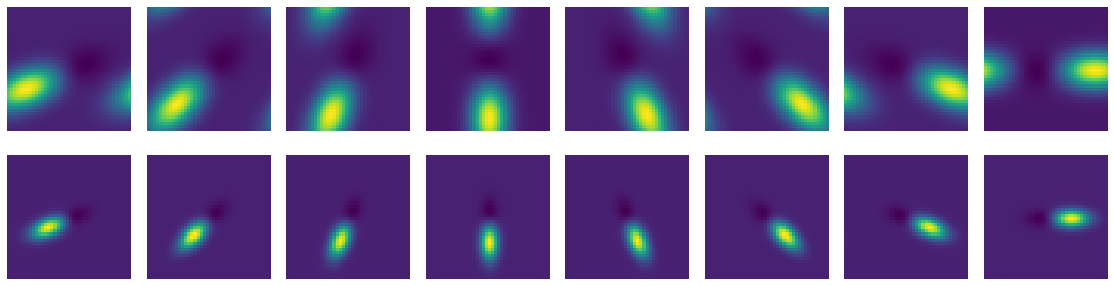

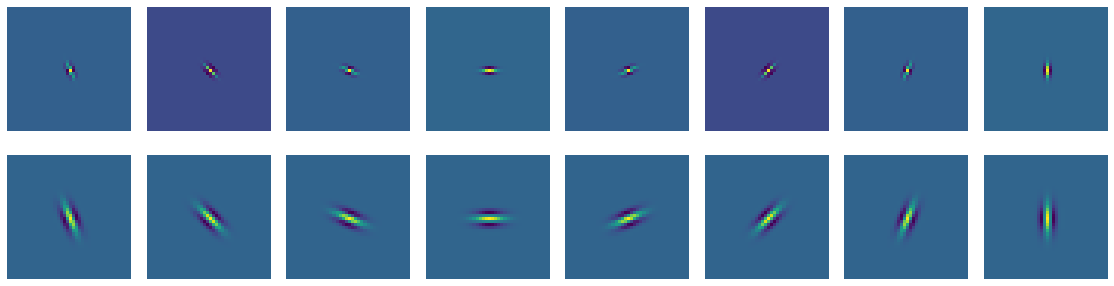

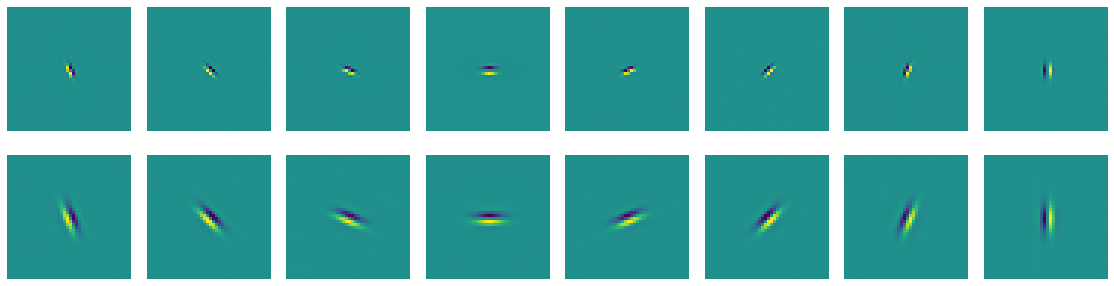

In [145]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
is_scattering_dif = False
if params['model']['mode'] == 'scattering_dif' or params['model']['mode'] == 'scattering':
    J = params['scattering']['J']
    M, N= params['preprocess']['dimension']['M'], params['preprocess']['dimension']['N']
    scattering = Scattering2D(J=J, shape=(M, N))
    K = 81*3
    model = LinearLayer(K, params['model']['width']).to(device)
    if use_cuda:
        scattering = scattering.cuda()

    orientations, xis, sigmas, slants = create_filters_params(J, scattering.L)
    psi = wavelets = morlets((scattering.M_padded, scattering.N_padded,), orientations, xis, sigmas, slants)
    # visualize wavlet filters before training
    filters_plots_before = {}
    for mode in ['fourier','real', 'imag' ]:
        f = get_filters_visualization(psi, num_row = 2 , num_col =8 , mode =mode)
        filters_plots_before [mode]  = f  
    if params['model']['mode'] == 'scattering_dif' :
        lr_scattering = params['model']['lr_scattering']  
        filters = make_filters_diff(psi)
        is_scattering_dif = True

In [47]:
wavelets.real.max()

tensor(31.2504)

In [50]:
psi[15][0].min()

tensor(-0.0966, device='cuda:0')

In [12]:
def create_filters_params(J, L):
    '''
        Create reusable filters parameters: orientations, xis, sigmas, sigmas
    '''
    orientations = []
    xis = []
    sigmas = []
    slants = []

    for j in range(J):
        for theta in range(L):
            sigmas.append(0.8 * 2**j)
            theta = ((int(L-L/2-1)-theta) * np.pi / L)
            xis.append(3.0 / 4.0 * np.pi /2**j)
            slants.append(4.0/L)
            orientations.append(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], np.float32))
            #R_inv = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.float32)
             
    xis = torch.FloatTensor(xis)
    sigmas = torch.FloatTensor(sigmas)
    slants = torch.FloatTensor(slants)
    orientations = torch.FloatTensor(orientations)   
    return orientations[:, 0], xis, sigmas, slants

In [120]:
orientations = torch.randn(16,2)

In [46]:
gaussian_bases = torch.randn(25, 2, 2)
wave_vectors = gaussian_bases[:, 0]
norm_factors = (gaussian_bases[:, 0] * gaussian_bases[:, 1]).sum(1) / (gaussian_bases[:, 0] * gaussian_bases[:, 0]).sum(1)
gaussian_bases[:, 1] -=  norm_factors[..., np.newaxis] * gaussian_bases[:, 0]
some_morlets = raw_morlets((64, 64), wave_vectors, gaussian_bases , fft=False, ifftshift=False)



In [10]:
def morlets(grid_or_shape, orientations, xis, sigmas, slants, device=None, morlet=True, ifftshift=True, fft=True):
    n_filters, ndim = orientations.shape
    if device is None:
        device = orientations.device
    orientations = orientations / (torch.norm(orientations, dim=1, keepdim=True) + 1e-19)
    wave_vectors = orientations * xis[:, np.newaxis]
    _, _, gauss_directions = torch.linalg.svd(orientations[:, np.newaxis])
    gauss_directions = gauss_directions / sigmas[:, np.newaxis, np.newaxis]
    indicator = torch.arange(ndim) < 1
    slant_modifications = (1.0 * indicator + slants[:, np.newaxis] * ~indicator).to(gauss_directions.device)
    gauss_directions = gauss_directions * slant_modifications[:, :, np.newaxis]
    wavelets = raw_morlets(grid_or_shape, wave_vectors, gauss_directions, morlet=morlet, 
                          ifftshift=ifftshift, fft=fft)
    return wavelets

In [9]:
def raw_morlets(grid_or_shape, wave_vectors, gaussian_bases, morlet=True, ifftshift=True, fft=True):
    n_filters, n_dim = wave_vectors.shape
    assert gaussian_bases.shape == (n_filters, n_dim, n_dim)
    device = wave_vectors.device
    if isinstance(grid_or_shape, tuple):
        shape = grid_or_shape
        ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
        grid = torch.stack(torch.meshgrid(*ranges), 0)
    else:
        shape = grid_or_shape.shape
        grid = grid
        _or_shape
    waves = torch.exp(1.0j * torch.matmul(grid.T, wave_vectors.T).T)
    gaussian_directions = torch.matmul(grid.T, gaussian_bases.T.reshape(n_dim, n_dim * n_filters)).T
    gaussian_directions = gaussian_directions.reshape((n_dim, n_filters) + shape)
    radii = torch.norm(gaussian_directions, dim=0)
    gaussians = torch.exp(-0.5 * radii ** 2)
    signal_dims = list(range(1, n_dim + 1))
    gabors = gaussians * waves
    gabors = gabors
    if morlet:
        gaussian_sums = gaussians.sum(dim=signal_dims, keepdim=True)
        gabor_sums = gabors.sum(dim=signal_dims, keepdim=True).real
        morlets = gabors - gabor_sums / gaussian_sums * gaussians
        filters = morlets
    else:
        filters = gabors
    if ifftshift:
        filters = torch.fft.ifftshift(filters, dim=signal_dims)
    if fft:
        filters = torch.fft.fftn(filters, dim=signal_dims)
    return filters

In [24]:
orientations, xis, sigmas, slants = create_filters_params(2,8)
wavelets = morlets((40, 40), orientations, xis, sigmas, slants, morlet=True, ifftshift=True, fft=True)


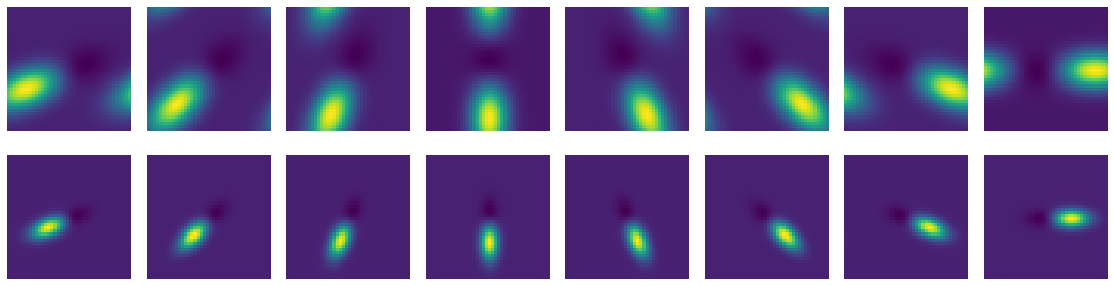

In [28]:
f = get_filters_visualization(wavelets.unsqueeze(2).real.contiguous(), num_row = 2 , num_col =8 , mode ='fourier')

In [32]:
wavelets[0].real.max()

tensor(7.8126)

In [33]:
psi

NameError: name 'psi' is not defined

In [18]:
def get_filters_visualization(psi, num_row = 2 , num_col =8 , mode ='fourier'):
    '''
        Function that logs the metrics on MLFLOW
        Params: 
        filters: psi filters
        num_row: number of rows in the visualization
        num_col: number of columns in the visualization
        mode: fourier, real or imag
    '''
    f, axarr = plt.subplots(num_row,num_col, figsize=(20, 5))
    count = 0
    for i in range(0, num_row) :
        for j in range(0, num_col) :
            if mode =='fourier':
                x =np.fft.fftshift(psi[count].squeeze().cpu().detach().numpy()).real
            elif mode == 'real':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).real
            elif mode == 'imag':
                x= np.fft.fftshift(np.fft.ifft2(psi[count].squeeze().cpu().detach().numpy())).imag
            else:
                raise NotImplemented(f"Model {params['name']} not implemented")
            axarr[i,j].imshow(x)
            #axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
            axarr[i,j].axis('off')
            count = count +1
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            axarr[i,j].set_aspect('equal')

    f.subplots_adjust(wspace=0, hspace=0.2)
    return f

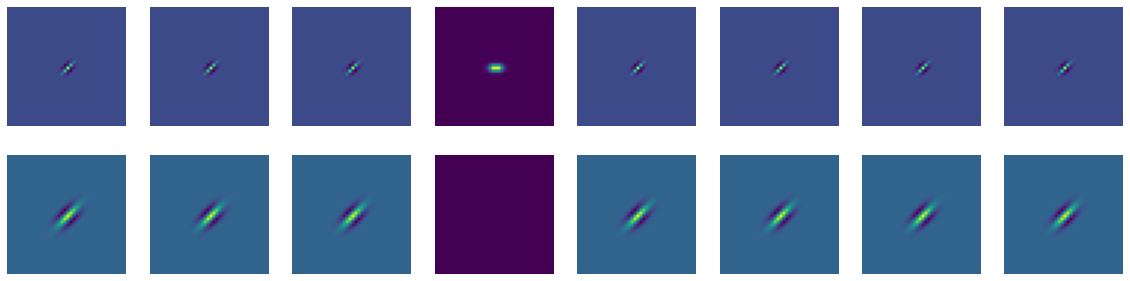

In [97]:
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        x= np.fft.fftshift(np.fft.ifft2(wavelets[count].squeeze().cpu().detach().numpy())).real
        axarr[i,j].imshow(x)
        #axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].axis('off')
        count = count +1

In [154]:
phi, psi  = scattering.load_filters()

In [172]:
for i,d in enumerate(psi):
    d[0]=None

In [174]:
psi

[{'j': 0, 'theta': 0, 0: None},
 {'j': 0, 'theta': 1, 0: None},
 {'j': 0, 'theta': 2, 0: None},
 {'j': 0, 'theta': 3, 0: None},
 {'j': 0, 'theta': 4, 0: None},
 {'j': 0, 'theta': 5, 0: None},
 {'j': 0, 'theta': 6, 0: None},
 {'j': 0, 'theta': 7, 0: None},
 {'j': 1, 'theta': 0, 0: None},
 {'j': 1, 'theta': 1, 0: None},
 {'j': 1, 'theta': 2, 0: None},
 {'j': 1, 'theta': 3, 0: None},
 {'j': 1, 'theta': 4, 0: None},
 {'j': 1, 'theta': 5, 0: None},
 {'j': 1, 'theta': 6, 0: None},
 {'j': 1, 'theta': 7, 0: None}]

In [169]:
psi[0][0]

tensor([[-1.8626e-07-7.4506e-09j, -2.6437e-01+1.3039e-08j,
         -4.6067e-01+2.4214e-08j,  ...,
          1.1402e+00+9.7850e-09j,  7.1404e-01+2.7001e-09j,
          3.2912e-01-2.6581e-08j],
        [ 1.2567e-01-5.9803e-10j, -1.5446e-01+5.8070e-09j,
         -3.5781e-01+5.2953e-09j,  ...,
          1.3955e+00+2.3411e-08j,  9.1011e-01+2.5658e-09j,
          4.8258e-01-3.4498e-08j],
        [ 2.4209e-01-8.3777e-09j, -4.2094e-02-7.2073e-09j,
         -2.4430e-01+6.6506e-09j,  ...,
          1.5920e+00-1.8925e-08j,  1.0650e+00+8.9459e-09j,
          6.1193e-01-2.8001e-08j],
        ...,
        [-2.5168e-01+1.2329e-08j, -4.2618e-01+2.6181e-08j,
         -5.6744e-01+6.6495e-08j,  ...,
          3.8475e-01+2.2955e-08j,  1.6455e-01+4.6426e-08j,
         -5.1459e-02-3.7671e-08j],
        [-2.0174e-01+2.7386e-09j, -4.1011e-01+1.1401e-08j,
         -5.7353e-01+1.2886e-08j,  ...,
          6.0404e-01+3.1728e-08j,  3.1756e-01+4.9715e-08j,
          4.4409e-02-1.4230e-08j],
        [-1.1473e-01-7

In [178]:
psi


[{'j': 0,
  'theta': 0,
  0: tensor([[[ 7.4506e-09],
           [ 4.0924e-02],
           [ 8.8786e-02],
           ...,
           [-7.3453e-02],
           [-5.7282e-02],
           [-3.2873e-02]],
  
          [[ 1.5627e-02],
           [ 6.0005e-02],
           [ 1.1317e-01],
           ...,
           [-6.0863e-02],
           [-4.4491e-02],
           [-1.9206e-02]],
  
          [[ 3.0103e-02],
           [ 7.6090e-02],
           [ 1.3243e-01],
           ...,
           [-4.6354e-02],
           [-3.0377e-02],
           [-5.2341e-03]],
  
          ...,
  
          [[-3.1295e-02],
           [-6.3985e-03],
           [ 2.0461e-02],
           ...,
           [-8.3423e-02],
           [-7.0557e-02],
           [-5.2992e-02]],
  
          [[-2.5085e-02],
           [ 5.5220e-03],
           [ 3.9486e-02],
           ...,
           [-8.5637e-02],
           [-7.1314e-02],
           [-5.0994e-02]],
  
          [[-1.4266e-02],
           [ 2.1871e-02],
           [ 6.3068e-02

In [175]:
phi, psi  = scattering.load_filters()

In [176]:
psi

[{'j': 0,
  'theta': 0,
  0: tensor([[[ 7.4506e-09],
           [ 4.0924e-02],
           [ 8.8786e-02],
           ...,
           [-7.3453e-02],
           [-5.7282e-02],
           [-3.2873e-02]],
  
          [[ 1.5627e-02],
           [ 6.0005e-02],
           [ 1.1317e-01],
           ...,
           [-6.0863e-02],
           [-4.4491e-02],
           [-1.9206e-02]],
  
          [[ 3.0103e-02],
           [ 7.6090e-02],
           [ 1.3243e-01],
           ...,
           [-4.6354e-02],
           [-3.0377e-02],
           [-5.2341e-03]],
  
          ...,
  
          [[-3.1295e-02],
           [-6.3985e-03],
           [ 2.0461e-02],
           ...,
           [-8.3423e-02],
           [-7.0557e-02],
           [-5.2992e-02]],
  
          [[-2.5085e-02],
           [ 5.5220e-03],
           [ 3.9486e-02],
           ...,
           [-8.5637e-02],
           [-7.1314e-02],
           [-5.0994e-02]],
  
          [[-1.4266e-02],
           [ 2.1871e-02],
           [ 6.3068e-02